# AlexNet implementation (with PyTorch)
Model from: https://pytorch.org/hub/pytorch_vision_alexnet/

Training loop from: https://kushaj.medium.com/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

## Import required modules

In [1]:
import torch
from torch import nn, optim
from copy import deepcopy
from PIL import Image
from torchvision import transforms
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import random
random.seed(1234) # reproducibility seed

## Get model

### Get pretrained model from source

In [3]:
alexnet = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet.eval()

Using cache found in /home/wrosales/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Data transformation

Set number of classifications labels

In [4]:
num_labels = 4 # CNV, DME, DRUSEN, NORMAL
labels_list = ["CNV", "DME", "DRUSEN", "NORMAL"]

#### Create train and test sets

In [5]:
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

data_dir = '/volume/OCT/OCT2017/'
sets = ["train", "val", "test"]

size = 224 # given by alexnet
batch_size = 32 # prefered by alexnet

# num_workers = 8 # only if multi-processing is needed

data_transforms = {
    set_type: transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) for set_type in sets
}

image_datasets = {
    set_type : ImageFolder(data_dir + set_type, transform=data_transforms[set_type])
    for set_type in sets
}

data_loader = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=batch_size,
                                   shuffle=True,
                                   pin_memory=True) for x in sets
}

Sets shape

In [6]:
for set_type in sets:
    print(f"Set: {set_type}. Images: {len(data_loader[set_type].dataset.imgs)}")

Set: train. Images: 83484
Set: val. Images: 32
Set: test. Images: 968


Check labels and images

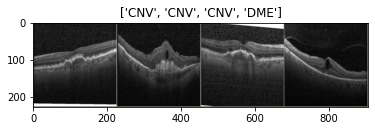

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

images, labels = next(iter(data_loader['val']))
grid_img = make_grid(images[:4], nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[:4]])

## LIMO model

### Modify architecture

In [8]:
def newAlexNet(num_labels):
    newAlexnet = deepcopy(alexnet)
    lastLayer = newAlexnet.classifier[-1] # get usual last layer
    newAlexnet.classifier[-1] = nn.Linear(lastLayer.in_features, num_labels) # modify last layer number of outputs (labels to be classified)
    return newAlexnet

limoAlexnet = newAlexNet(num_labels)

### Set hiperparameters

In [9]:
learning_rate = 0.001
momentum = 0.9
epochs = 10

### Loss function, optimizer and scheduler

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(limoAlexnet.parameters(), lr=learning_rate, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

### Train loop

In [11]:
def train(model, data_loader, criterion, optimizer, scheduler = None, num_epochs=100, seed=None):
    since = time.time()
    if seed:
        random .seed(seed)
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # You perform validation test after every epoch
        for phase in ["train", "val"]:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0; running_corrects = 0;
            
            num_batches = int(len(data_loader[phase].dataset) / batch_size)
            
            for idx, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if idx%200 == 0 or idx == num_batches - 1:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} steps in progress'.format(epoch+1, idx+1, num_batches))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                if scheduler:
                    scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

### Train model with train set

In [12]:
trainedLimoModel = train(limoAlexnet, data_loader, loss_fn, optimizer, scheduler, epochs, seed=123)

Epoch 1/10
---------------
Epoch 1: 1/2608 steps in progress
Epoch 1: 201/2608 steps in progress
Epoch 1: 401/2608 steps in progress
Epoch 1: 601/2608 steps in progress
Epoch 1: 801/2608 steps in progress
Epoch 1: 1001/2608 steps in progress
Epoch 1: 1201/2608 steps in progress
Epoch 1: 1401/2608 steps in progress
Epoch 1: 1601/2608 steps in progress
Epoch 1: 1801/2608 steps in progress
Epoch 1: 2001/2608 steps in progress
Epoch 1: 2201/2608 steps in progress
Epoch 1: 2401/2608 steps in progress
Epoch 1: 2601/2608 steps in progress
Epoch 1: 2608/2608 steps in progress
train Loss: 0.2793 Acc: 0.9039
Epoch 1: 1/1 steps in progress
val Loss: 0.0247 Acc: 1.0000

Epoch 2/10
---------------
Epoch 2: 1/2608 steps in progress
Epoch 2: 201/2608 steps in progress
Epoch 2: 401/2608 steps in progress
Epoch 2: 601/2608 steps in progress
Epoch 2: 801/2608 steps in progress
Epoch 2: 1001/2608 steps in progress
Epoch 2: 1201/2608 steps in progress
Epoch 2: 1401/2608 steps in progress
Epoch 2: 1601/260

Evaluate model over test set

In [13]:
testAcc = 0
trainedLimoModel.eval()
for batchNum, (inputs, labels) in enumerate(data_loader["test"]):
    outputs = trainedLimoModel(inputs)
    _, preds = torch.max(outputs, 1)
    testAcc += torch.sum(preds == labels.data)
print(f'Test set accuracy: {testAcc / len(data_loader["test"].dataset)}')

Test set accuracy: 0.9958677887916565
